In [32]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [33]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

In [34]:
df=pd.read_csv('00d-ROI_near_miss_results.txt',sep=',')

data = pd.read_csv('00c-near_misses.txt',index_col=0)
data = data[data['Time'].isin(np.arange(1.25,21.25,1.25))]
data['condition'] = data['Time'].apply(lambda time: 'approach' if time < 11.25 else 'retreat')

In [36]:
df.to_csv('results_Gang.csv')

In [5]:
z_crit = norm.ppf(0.975)

In [37]:
def CI(cols):
    mean = cols[0]
    zscore = cols[1]
    return (mean - (z_crit*mean/zscore), mean + (z_crit*mean/zscore))

def get_CI(df):
    df['CI'] = df.apply(CI,axis=1)
    df['low'] = df['CI'].apply(lambda tup: tup[0])
    df['high'] = df['CI'].apply(lambda tup: tup[1])
    df.drop('CI',axis=1,inplace=True)
    return df

def plot(df,mean_colname,z_colname):
    effect_df = get_CI(df[[mean_colname,z_colname]])
    plt.figure(figsize=(10,6))
    plt.errorbar(x=effect_df.index,y=effect_df[mean_colname],
                 yerr = (effect_df['high'] - effect_df['low'])/2,
                 marker='o',capsize=5)
    _=plt.axhline(y=0,linestyle = '--',c='k')
    _=plt.xticks(rotation=90,fontsize=12)
    _=plt.title(mean_colname,fontsize=18)
    _=plt.ylabel("Estimate",fontsize=12)

def plot2(df,mean_colname,z_colname):
    effect_df = get_CI(df[[mean_colname,z_colname]])
    plt.figure(figsize=(10,6))
    plt.plot(effect_df.index,effect_df[mean_colname],marker='o')
    plt.fill_between(effect_df.index,effect_df['low'],effect_df['high'],
                     alpha=0.3)
    plt.axhline(y=0,linestyle = '--')
    _=plt.xticks(rotation=90,fontsize=12)
    _=plt.title(mean_colname,fontsize=18)

## Intercept (average activation acorss groups, TRs, conditions)

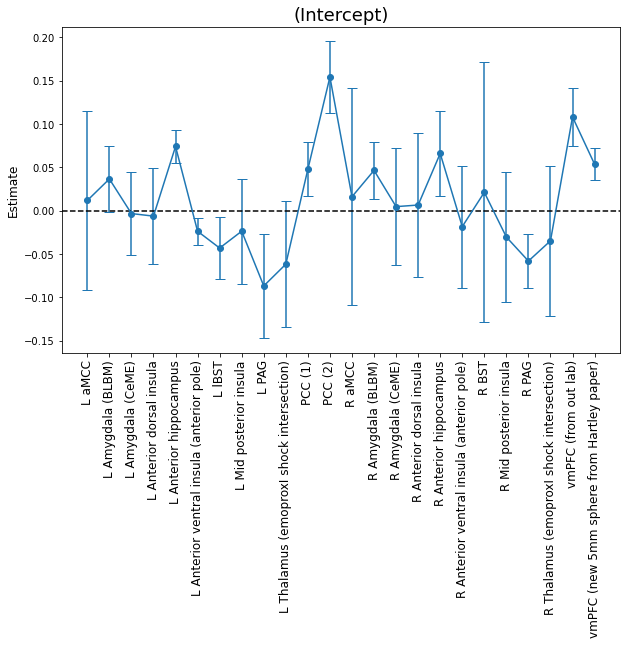

In [38]:
plot(df,'(Intercept)','(Intercept)-Z')

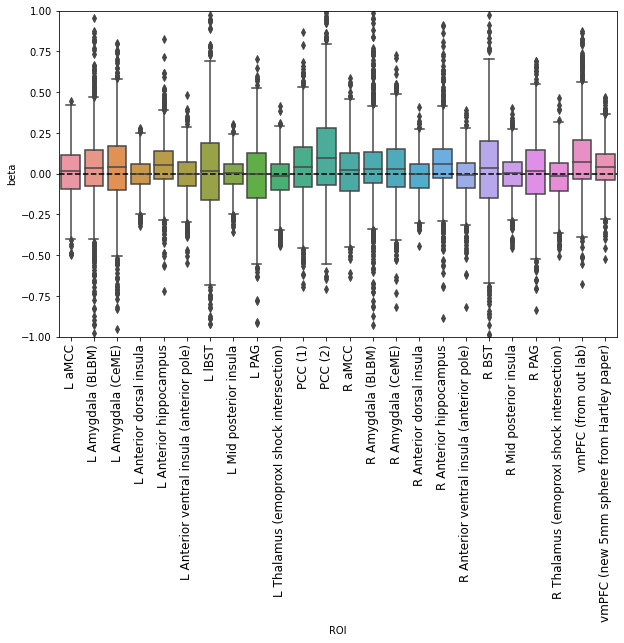

In [39]:
plt.figure(figsize=(10,6))
sns.boxplot(x='ROI',y='beta',data=data,order=df.index)
_=plt.xticks(rotation=90)
_=plt.ylim(-1,1)
_=plt.axhline(y=0,linestyle = '--',c='k')
_=plt.xticks(rotation=90,fontsize=12)

Observation:  
- Significant activation/deactivation in following ROIs:
    - Activation
        - Left & right anterior hippocampus 
        - PCC 1&2
        - Right amygdala (BLBM)
        - vmPFC (both)
    - Deactivation
        - Left anterior ventral insula (anterior pole)
        - Left BST
        - Left & Right PAG

## Group (control/uncontrol)

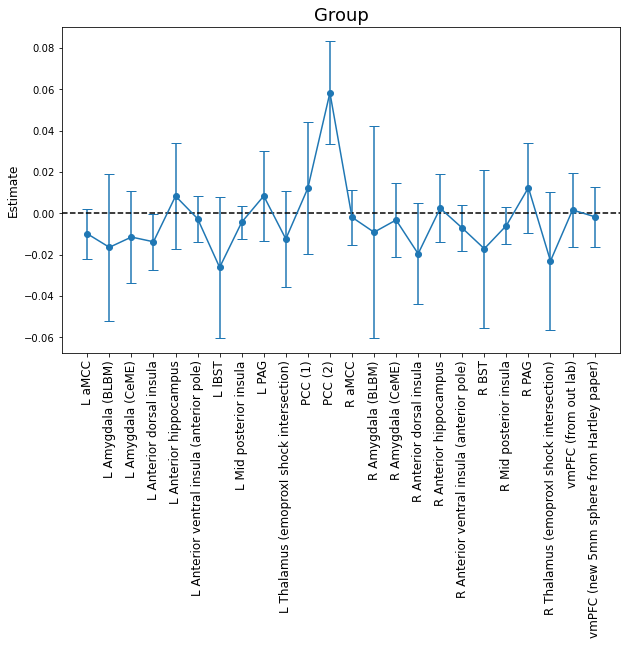

In [40]:
plot(df,'Group','Group-Z')

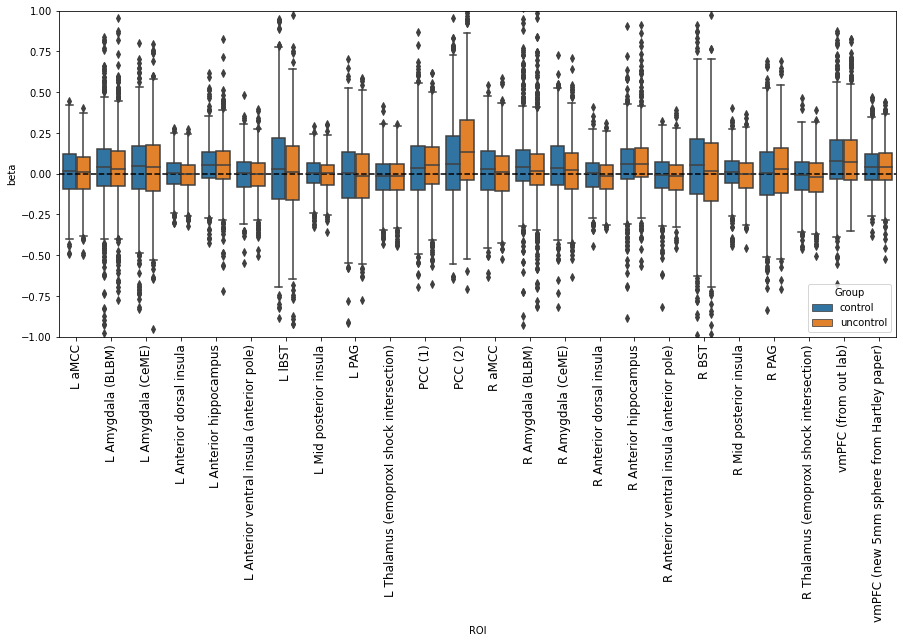

In [41]:
plt.figure(figsize=(15,6))
sns.boxplot(x='ROI',y='beta',data=data,order=df.index,hue='Group')
_=plt.xticks(rotation=90)
_=plt.ylim(-1,1)
_=plt.axhline(y=0,linestyle = '--',c='k')
_=plt.xticks(rotation=90,fontsize=12)

Observation:  
- Significant difference in activation (averaged across conditions and TR) between groups (control and uncontrol) in following ROI:
    - PCC (2)

## Condition (approach/retreat)

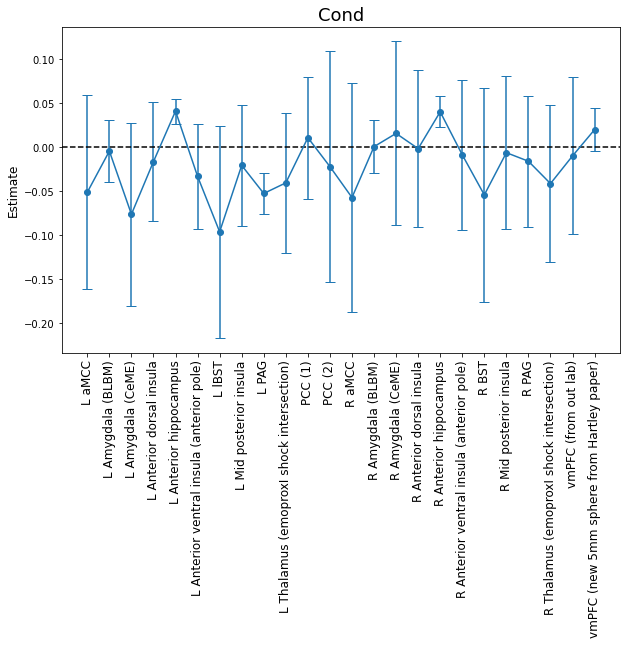

In [42]:
plot(df,'Cond','Cond-Z')

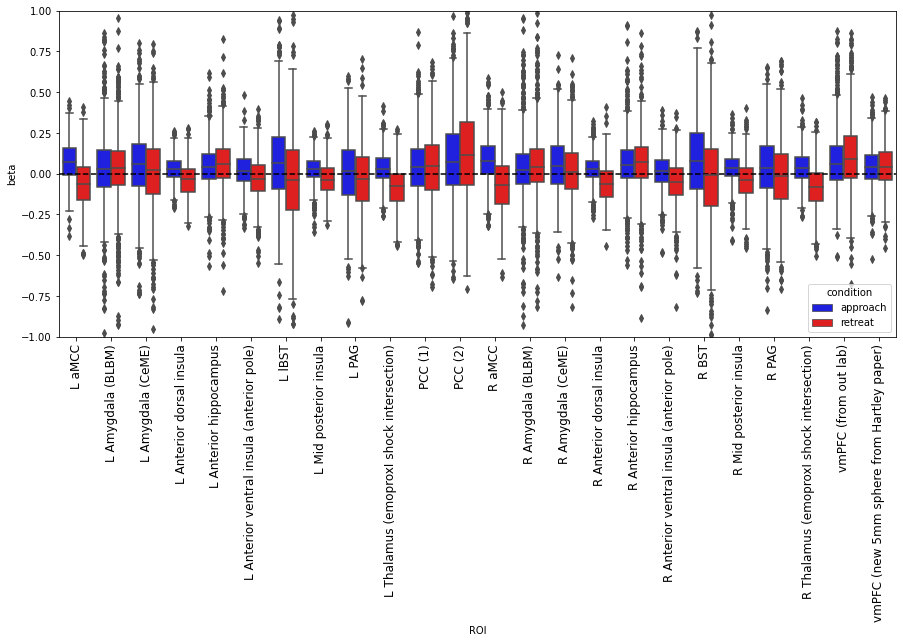

In [43]:
plt.figure(figsize=(15,6))
sns.boxplot(x='ROI',y='beta',data=data,order=df.index,hue='condition',palette=['blue','red'])
_=plt.xticks(rotation=90)
_=plt.ylim(-1,1)
_=plt.axhline(y=0,linestyle = '--',c='k')
_=plt.xticks(rotation=90,fontsize=12)

Observation:  
- Significant difference in activation (averaged across groups and TR) between approach and retreat in following ROI:
    - Left & right anterior hippocampus

## Condition-Group Interaction

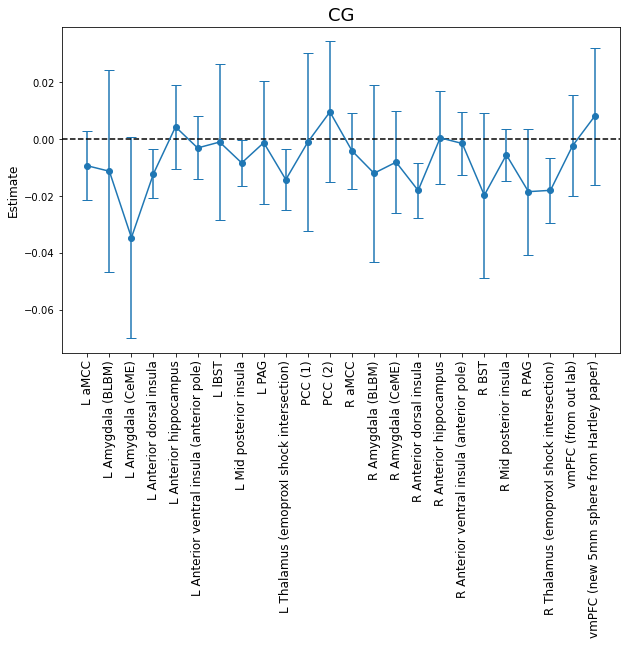

In [44]:
plot(df,'CG','CG-Z')

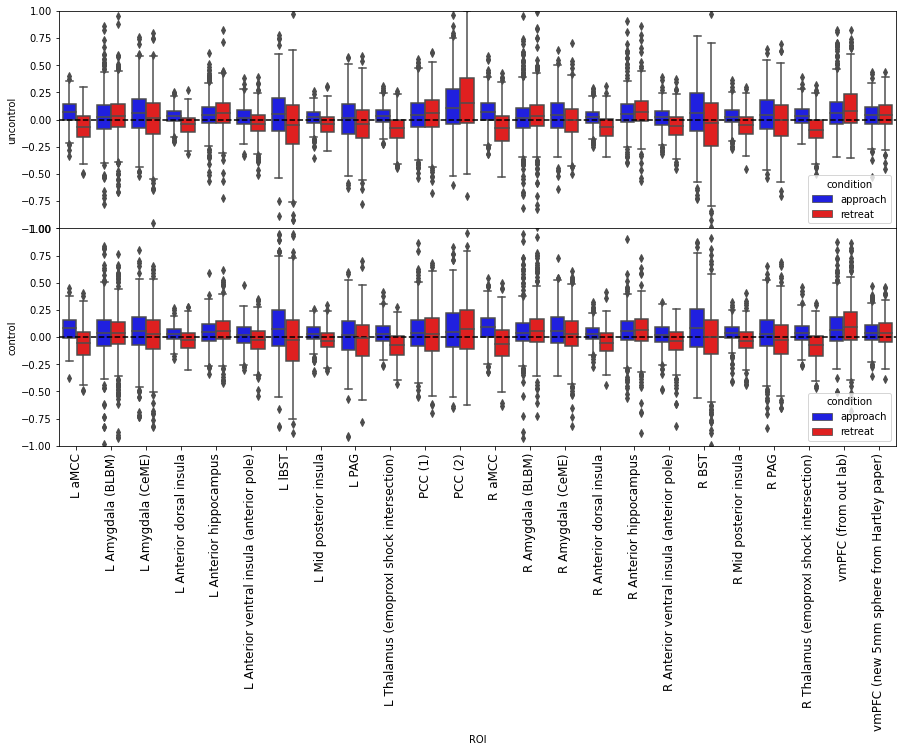

In [45]:
plt.figure(figsize=(15,8))
plt.subplots_adjust(wspace=0,hspace=0)
plt.subplot(2,1,1)
sns.boxplot(x='ROI',y='beta',hue='condition',data=data[data['Group']=='uncontrol'],order=df.index,palette=['blue','red'])
plt.ylabel('uncontrol')
plt.tick_params(labelbottom=False)   
plt.xlabel(None)
_=plt.ylim(-1,1)
_=plt.axhline(y=0,linestyle = '--',c='k')
plt.subplot(2,1,2)
sns.boxplot(x='ROI',y='beta',hue='condition',data=data[data['Group']=='control'],order=df.index,palette=['blue','red'])
plt.xticks(rotation=90,fontsize=12)
plt.ylabel('control')
_=plt.ylim(-1,1)
_=plt.axhline(y=0,linestyle = '--',c='k')

## Timepoint (TR)

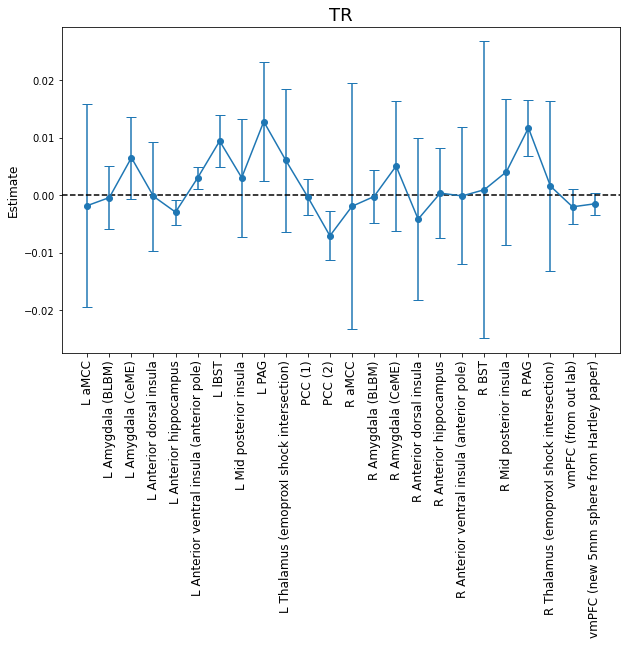

In [46]:
plot(df,'TR','TR-Z')

## Group-TR Interaction

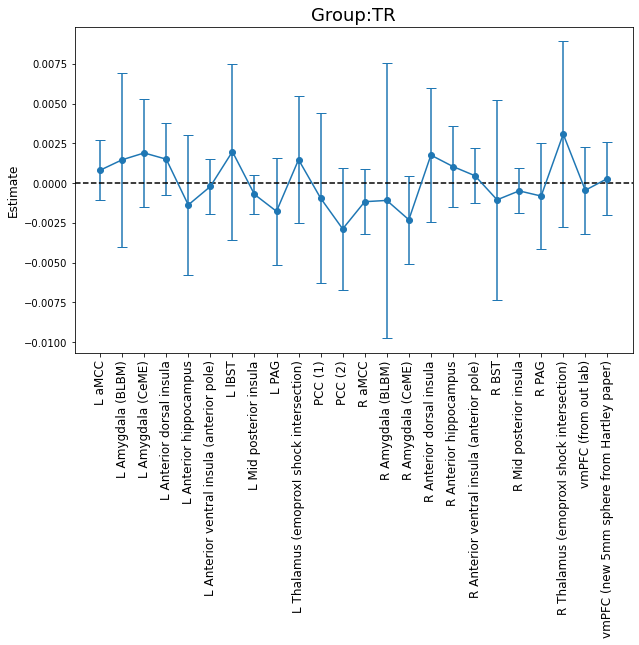

In [47]:
plot(df,'Group:TR','Group:TR-Z')

## Condition-TR Interaction

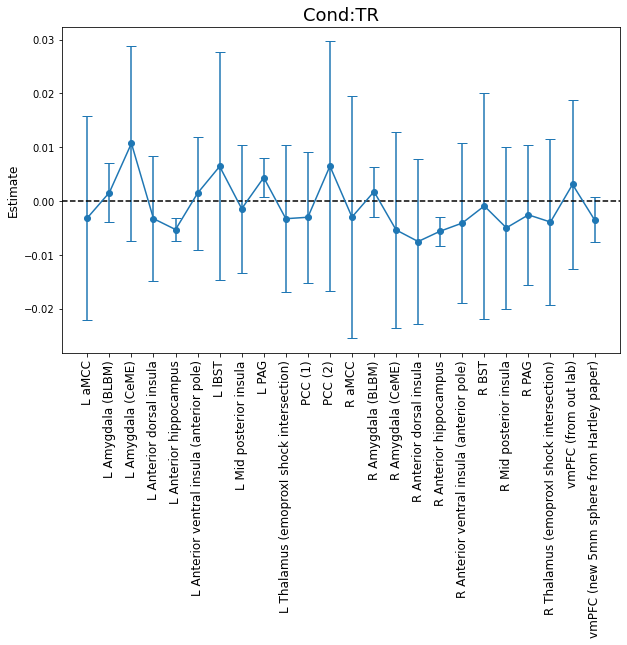

In [48]:
plot(df,'Cond:TR','Cond:TR-Z')

## Condition-Group-TR Intercation

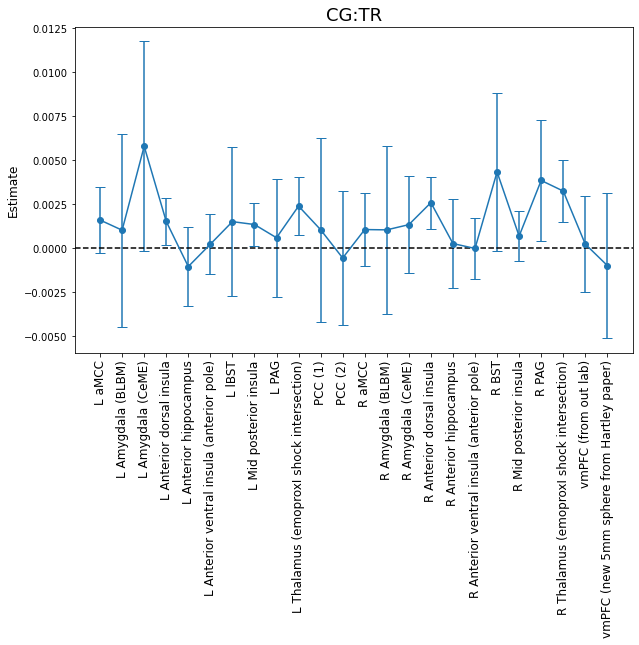

In [49]:
plot(df,'CG:TR','CG:TR-Z')

# Non-Linear Effects (Chi-square with 2 DFs)

In [50]:
nonlin_ef = df.iloc[:,16:20]
nonlin_ef = nonlin_ef.stack().to_frame().reset_index()
nonlin_ef.columns = ['ROI','effect','estimate']

s(TR):Group = TR-group interaction
s(TR):Cond = TR-condition interaction
s(TR):CG = TR-condition-group interaction


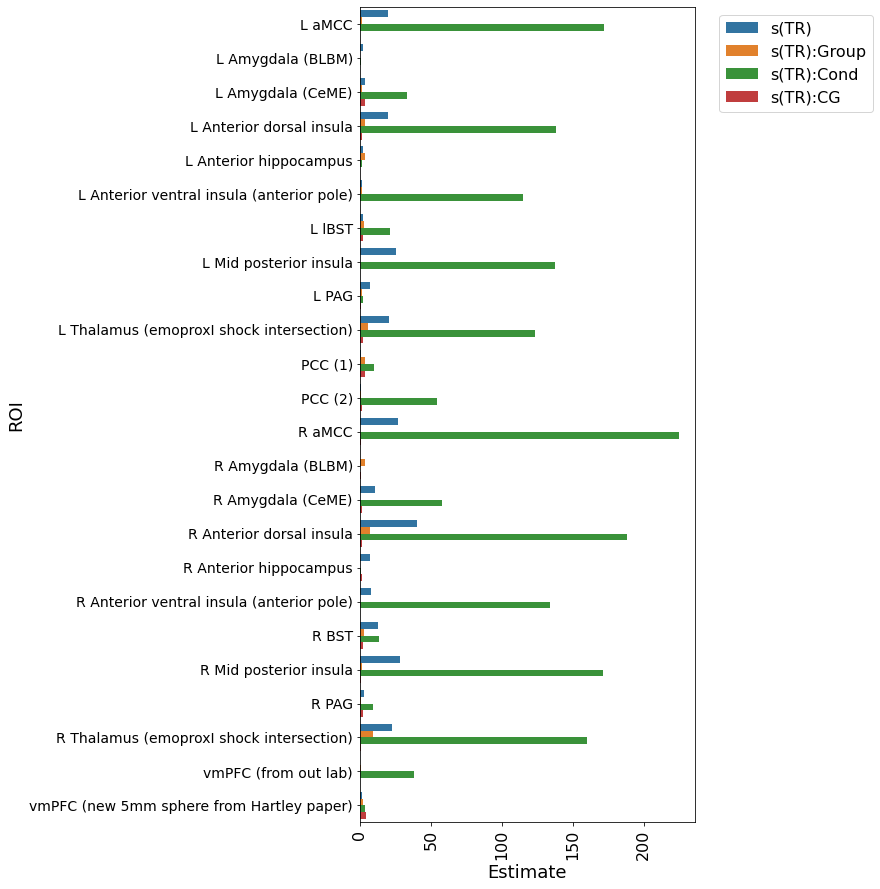

In [51]:
plt.figure(figsize = (6,15))
sns.barplot(y='ROI',x='estimate',hue='effect',data=nonlin_ef,orient='h')
_=plt.xticks(rotation = 90,fontsize=16)
_=plt.yticks(fontsize=14)
_=plt.legend(fontsize=16,bbox_to_anchor=(1.05,1))
_=plt.xlabel('Estimate',fontsize=18)
_=plt.ylabel('ROI',fontsize=18)
print('s(TR):Group = TR-group interaction')
print('s(TR):Cond = TR-condition interaction')
print('s(TR):CG = TR-condition-group interaction')

# Estimates
## Normal Estimates


In [52]:
mean_resp = data.groupby(['Group','condition','ROI','Time'])['beta'].mean()
mean_resp.name = 'response'
mean_resp = mean_resp.to_frame().reset_index()
mean_resp.head()

,Group,condition,ROI,Time,response
0,control,approach,L Amygdala (BLBM),1.25,0.095935
1,control,approach,L Amygdala (BLBM),2.50,0.004387
2,control,approach,L Amygdala (BLBM),3.75,0.032831
3,control,approach,L Amygdala (BLBM),5.00,0.054379
4,control,approach,L Amygdala (BLBM),6.25,0.054238


## Smooth Spline Estimates

In [53]:
resp = df.iloc[:,22:86][[col for col in df.iloc[:,22:86] if 'se' not in col]]
resp = resp.stack().to_frame().reset_index()
resp.columns = ['ROI','temp','response']
resp['Group'] = resp['temp'].apply(lambda temp: 'control' if temp[0] == 'C' else 'uncontrol')
resp['condition'] = resp['temp'].apply(lambda temp: 'approach' if temp[1] == 'A' else 'retreat')
resp['TR'] = resp['temp'].apply(lambda temp: float(temp[3:]))
resp.drop('temp',axis=1,inplace=True)


se = df.iloc[:,22:86][[col for col in df.iloc[:,22:86] if 'se' in col]]
se = se.stack().to_frame().reset_index()
se.columns = ['ROI','temp','se']
se['Group'] = se['temp'].apply(lambda temp: 'control' if temp[0] == 'C' else 'uncontrol')
se['condition'] = se['temp'].apply(lambda temp: 'approach' if temp[1] == 'A' else 'retreat')
se['TR'] = se['temp'].apply(lambda temp: float(temp[3:-2]))
se.drop('temp',axis=1,inplace=True)

resp = resp.merge(se)
resp['Time'] = resp.TR*1.25
resp.loc[resp['condition']=='retreat','Time'] = resp.loc[resp['condition']=='retreat','Time'] + 10
resp.head()

,ROI,response,Group,condition,TR,se,Time
0,L aMCC,-0.002591,control,approach,1.0,0.011103,1.25
1,L aMCC,0.061185,control,approach,2.0,0.011496,2.50
2,L aMCC,0.098682,control,approach,3.0,0.011086,3.75
3,L aMCC,0.112053,control,approach,4.0,0.010964,5.00
4,L aMCC,0.115982,control,approach,5.0,0.011033,6.25


# Plots

In [54]:
from scipy.stats import t as tdist
critT = tdist(df=60).ppf(0.975)

In [55]:
rois = resp.ROI.unique()
t = resp.Time.unique()

In [56]:
from IPython.display import HTML

def multi_table(table_list):
    '''
    Accepts a list of IpyTable...
    '''
    return HTML(
        '<table><tr style="background-color:white;">' +
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) + 
        '</tr></table>'
    )

In [57]:
multi_table([resp.head(),mean_resp.head()])

## Control: regular vs. smooth spline estimates

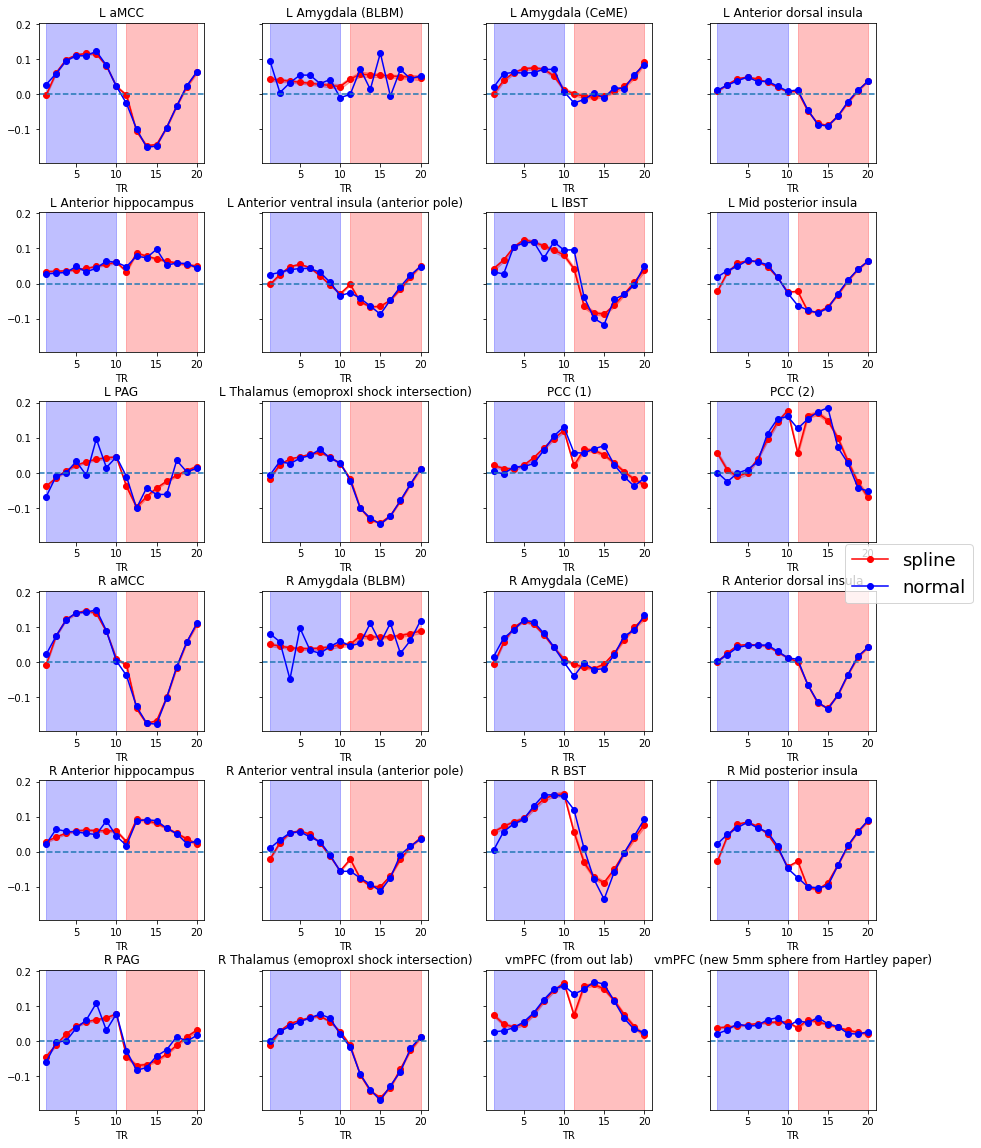

In [58]:
fig, axes = plt.subplots(nrows=6,ncols=4,figsize=(15,20),sharey=True)
axes = axes.flatten()

fig.subplots_adjust(wspace=0.35,hspace=0.35)

for i, roi in enumerate(rois):
    gang = resp[(resp['ROI']==roi) & (resp['Group']=='control')]
    
    axes[i].plot(t,gang['response'],label="spline",color='red',marker='o')
    axes[i].fill_between(t,
                         gang['response'] - (critT*(gang['se']/np.sqrt(61))),
                         gang['response'] + (critT*(gang['se']/np.sqrt(61))),
                         alpha=0.3,color='red')
    
    chirag = mean_resp[(mean_resp['ROI']==roi) & (mean_resp['Group']=='control')]
    axes[i].plot(t,chirag['response'],label='normal',color='blue',marker='o')
    
    axes[i].axvspan(xmin=1.25,xmax=10,color='blue',alpha=0.25)
    axes[i].axvspan(xmin=11.25,xmax=20,color='red',alpha=0.25)
    
    axes[i].axhline(y=0,linestyle = '--')
    axes[i].set_title(roi)
    axes[i].set_xlabel('TR')
    
fig.legend(axes[i].get_legend_handles_labels()[0],
       labels=axes[i].get_legend_handles_labels()[1],
       loc='center right',
       #bbox_to_anchor=[1,1],
       fontsize=18)

## Uncontrol: regular vs. smooth spline estimates

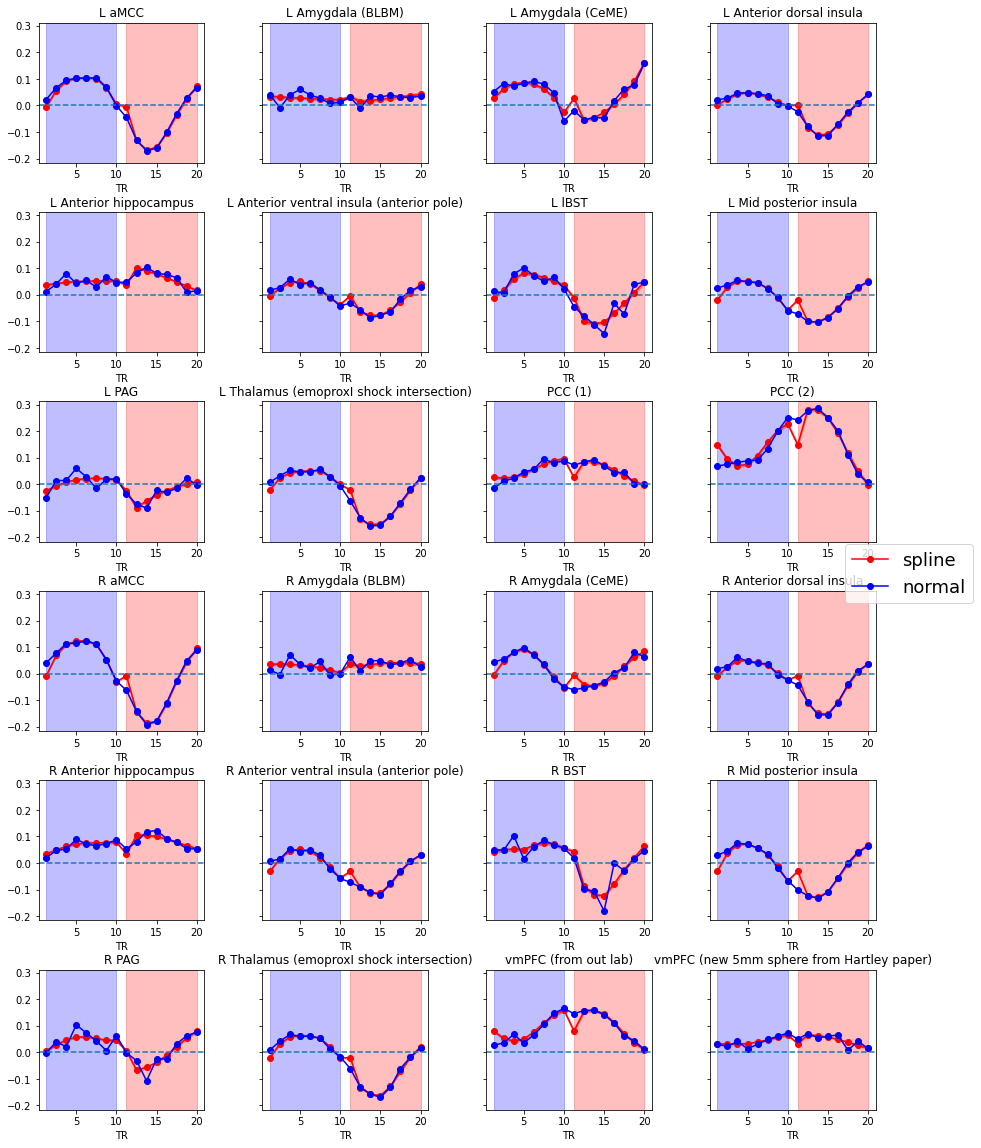

In [59]:
fig, axes = plt.subplots(nrows=6,ncols=4,figsize=(15,20),sharey=True)
axes = axes.flatten()

fig.subplots_adjust(wspace=0.35,hspace=0.35)

for i, roi in enumerate(rois):
    gang = resp[(resp['ROI']==roi) & (resp['Group']=='uncontrol')]
    
    axes[i].plot(t,gang['response'],label="spline",color='red',marker='o')
    axes[i].fill_between(t,
                         gang['response'] - (critT*(gang['se']/np.sqrt(61))),
                         gang['response'] + (critT*(gang['se']/np.sqrt(61))),
                         alpha=0.3,color='red')
    
    chirag = mean_resp[(mean_resp['ROI']==roi) & (mean_resp['Group']=='uncontrol')]
    axes[i].plot(t,chirag['response'],label='normal',color='blue',marker='o')
    
    axes[i].axvspan(xmin=1.25,xmax=10,color='blue',alpha=0.25)
    axes[i].axvspan(xmin=11.25,xmax=20,color='red',alpha=0.25)
    
    axes[i].axhline(y=0,linestyle = '--')
    axes[i].set_title(roi)
    axes[i].set_xlabel('TR')
    
fig.legend(axes[i].get_legend_handles_labels()[0],
       labels=axes[i].get_legend_handles_labels()[1],
       loc='center right',
       #bbox_to_anchor=[1,1],
       fontsize=18)

## Regular estimates: uncontrol vs. control

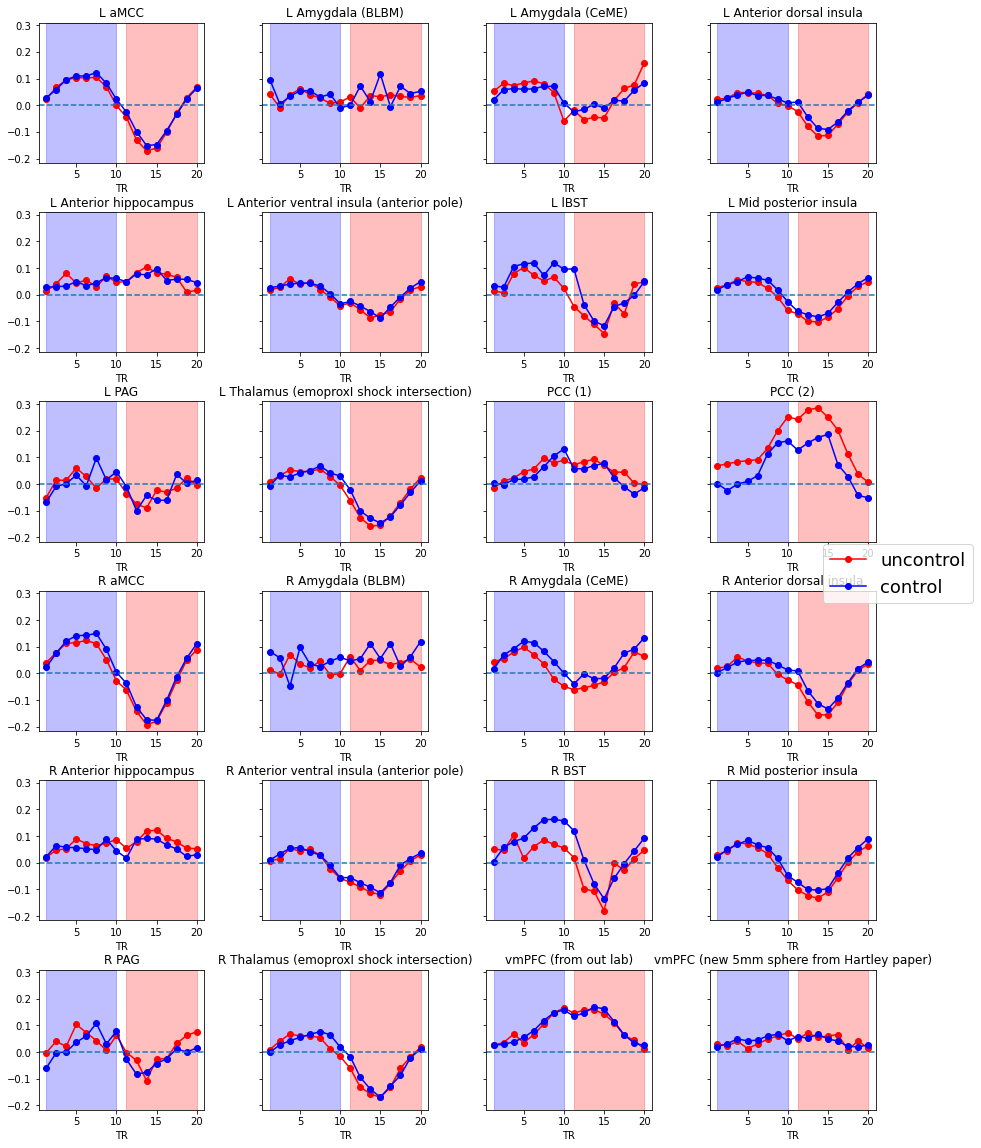

In [60]:
fig, axes = plt.subplots(nrows=6,ncols=4,figsize=(15,20),sharey=True)
axes = axes.flatten()

fig.subplots_adjust(wspace=0.35,hspace=0.35)

for i, roi in enumerate(rois):
    
    uncon = mean_resp[(mean_resp['ROI']==roi) & (mean_resp['Group']=='uncontrol')]
    axes[i].plot(t,uncon['response'],label="uncontrol",color='red',marker='o')
    
    con = mean_resp[(mean_resp['ROI']==roi) & (mean_resp['Group']=='control')]
    axes[i].plot(t,con['response'],label='control',color='blue',marker='o')
    
    axes[i].axvspan(xmin=1.25,xmax=10,color='blue',alpha=0.25)
    axes[i].axvspan(xmin=11.25,xmax=20,color='red',alpha=0.25)
    axes[i].axhline(y=0,linestyle = '--')
    axes[i].set_title(roi)
    axes[i].set_xlabel('TR')
    
fig.legend(axes[i].get_legend_handles_labels()[0],
       labels=axes[i].get_legend_handles_labels()[1],
       loc='center right',
       #bbox_to_anchor=[1,1],
       fontsize=18)

## Smooth spline estimates: uncontrol vs. control

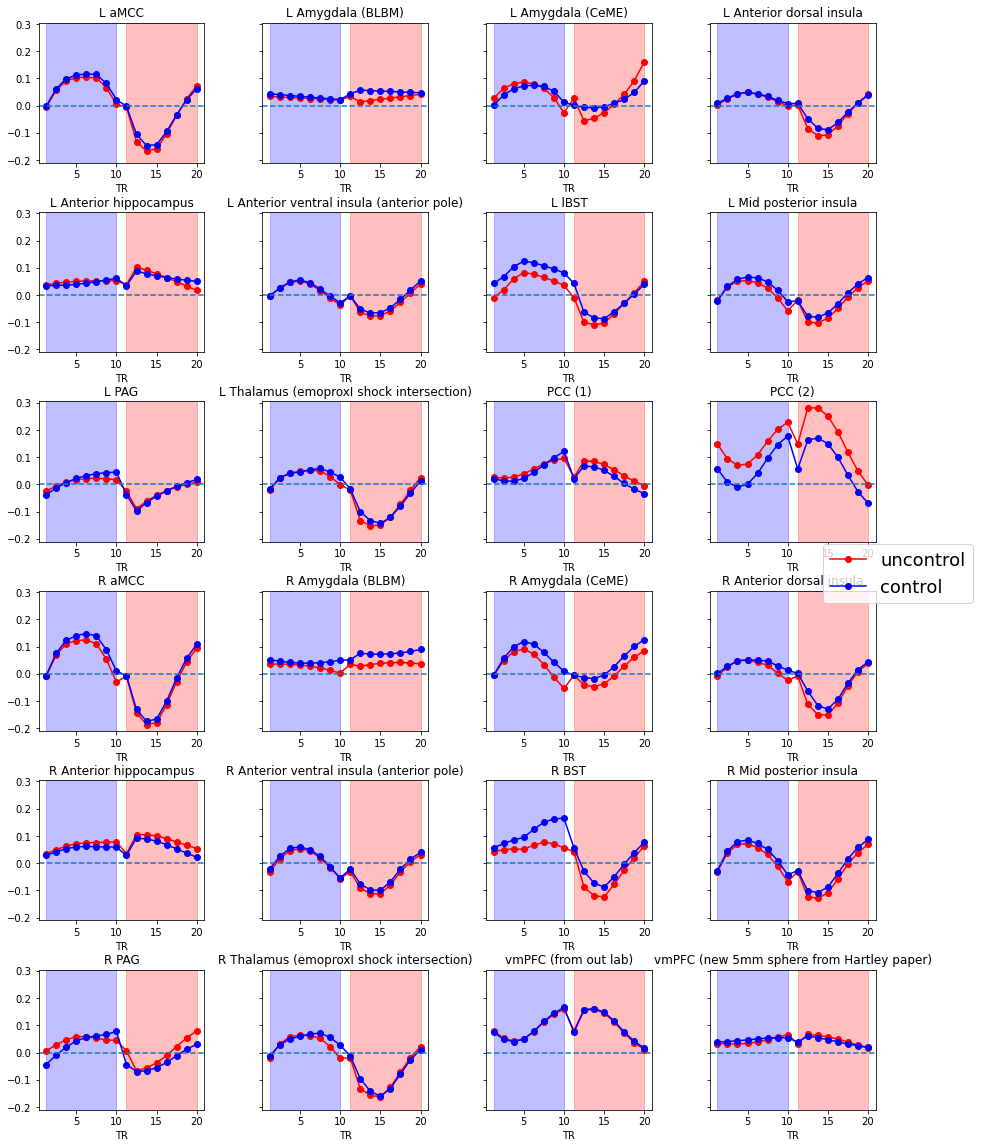

In [61]:
fig, axes = plt.subplots(nrows=6,ncols=4,figsize=(15,20),sharey=True)
axes = axes.flatten()

fig.subplots_adjust(wspace=0.35,hspace=0.35)

for i, roi in enumerate(rois):
    
    uncon = resp[(resp['ROI']==roi) & (resp['Group']=='uncontrol')]
    axes[i].plot(t,uncon['response'],label="uncontrol",color='red',marker='o')
    
    con = resp[(resp['ROI']==roi) & (resp['Group']=='control')]
    axes[i].plot(t,con['response'],label='control',color='blue',marker='o')
    
    axes[i].axvspan(xmin=1.25,xmax=10,color='blue',alpha=0.25)
    axes[i].axvspan(xmin=11.25,xmax=20,color='red',alpha=0.25)
    axes[i].axhline(y=0,linestyle = '--')
    axes[i].set_title(roi)
    axes[i].set_xlabel('TR')
    
fig.legend(axes[i].get_legend_handles_labels()[0],
       labels=axes[i].get_legend_handles_labels()[1],
       loc='center right',
       #bbox_to_anchor=[1,1],
       fontsize=18)